Deep Learning
=============

Getting data
------------

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from urllib.request import urlretrieve, urlopen
import pickle

%matplotlib inline

First, download the dataset. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. 

In [37]:
url = 'http://commondatastorage.googleapis.com/books1000/'
file_name1 = 'notMNIST_large.tar.gz'
file_name2 = 'notMNIST_small.tar.gz'

# retreiving size of each files
file1_size = int(urlopen(url+file_name1).info().get_all('Content-Length')[0])
file2_size = int(urlopen(url+file_name2).info().get_all('Content-Length')[0])

In [126]:
# report hook
last_percent_reported = None
def reporthook(count, blockSize, totalSize):
    """
        A hook to report the progress of a download. 
        Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("\r%s%%" % percent)
            sys.stdout.flush()
        last_percent_reported = percent

In [139]:
def download(url,file_name,size):
    #if not os.path.exists('./data'):
    #    os.mkdir('./data')
    #dest_file = './data/'+file_name
    
    if os.path.exists(file_name):
        print('The file',file_name,'is laready downloaded')
    else:    
        filename, _ = urlretrieve(url+file_name,file_name,reporthook=reporthook)
        statinfo = os.stat(file_name)
        if statinfo.st_size == size:
            print('\nFound and verified', file_name)
        else:
            raise Exception(
              'Failed to verify ' + file_name + '. Can you get to it with a browser?')

In [140]:
#train_filename, _ = download(url,)

download(url,file_name1,file1_size)
download(url,file_name2,file2_size)

100%
Found and verified notMNIST_large.tar.gz
100%
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [143]:
file_name1.split('.')[0]

'notMNIST_large'

In [334]:
num_classes = 10
def extract(filename):
    root = filename.split('.')[0]  # remove .tar.gz
    if os.path.exists(root):
        print('%s is already present - Skipping extraction.' % root)
        return [os.path.join(root,d) for d in sorted(os.listdir(root))
                if os.path.isdir(os.path.join(root,d))]
    else:
        print('Extracting data for %s. Please wait.' % root)
        with tarfile.open(filename) as tar:      
            tar.extractall('./')
        data_folders = [os.path.join(root,d) for d in sorted(os.listdir(root))
                if os.path.isdir(os.path.join(root,d))]
        if len(data_folders) != num_classes:
            raise Exception('Expected %d folders. Found %d instead.' % (
                num_classes, len(data_folders)))
        print('Extrcation done !')
        return data_folders

train_folders = extract(file_name1)
test_folders  = extract(file_name2)

notMNIST_large is already present - Skipping extraction.
notMNIST_small is already present - Skipping extraction.


Let's display a sample of the images that we just downloaded using IPhyton.display

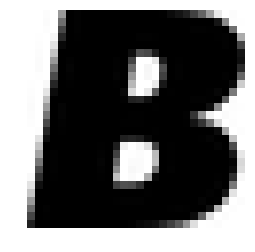

In [330]:
def showimage(label,path):
    path = os.path.join(path,label)
    files = os.listdir(path)
    k = np.random.randint(0,len(files))
    X = ndimage.imread(os.path.join(path,files[k]))
    plt.imshow(X,cmap=plt.cm.binary)
    plt.axis('off');
    return X

X = showimage('B','notMNIST_small/')

Now let's convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [337]:
image_size  = 28         # Pixel width and height.
pixel_depth = 255        # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """
    Load data for a single letter label.
    """
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) - 
                        pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images += 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename):
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets  = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Pickling notMNIST_large/B.pickle.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Pickling notMNIST_large/C.pickle.
notMNIST_large/C
Pickling notMNIST_large/D.pickle.
notMNIST_large/D
Could not read: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : cannot identify image file '

---
Let's verify that the data still looks good by displaying a sample of the labels and images from the ndarray. 


notMNIST_small/J


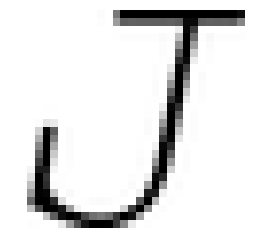

In [349]:
#%%capture
letter = load_letter('notMNIST_small/J',1000)
plt.imshow(letter[20,:],cmap=plt.cm.binary)
plt.axis('off');

---
Another check: we expect the data to be balanced across classes. Let's verify that.


In [352]:
%%capture
letters = []
for folder in test_folders:
    letter = load_letter(folder,1000)
    letters.append(letter)

In [353]:
for letter in letters:
    print(letter.shape)

(1872, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)


---
Merging and pruning the training data. The labels will be stored into a separate array of integers 0 through 9.
We will also create a validation dataset for hyperparameter tuning.

In [355]:
train_datasets

['notMNIST_large/A.pickle',
 'notMNIST_large/B.pickle',
 'notMNIST_large/C.pickle',
 'notMNIST_large/D.pickle',
 'notMNIST_large/E.pickle',
 'notMNIST_large/F.pickle',
 'notMNIST_large/G.pickle',
 'notMNIST_large/H.pickle',
 'notMNIST_large/I.pickle',
 'notMNIST_large/J.pickle']

In [356]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels  = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
                print('Unable to process data from', pickle_file, ':', e)
                raise

    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
          train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [357]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Finally, let's save the data for later reuse:

In [359]:
pickle_file = 'notMNIST.pickle'

try:
    save = {
        'train_dataset': train_dataset,
        'train_labels' : train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels' : valid_labels,
        'test_dataset' : test_dataset,
        'test_labels'  : test_labels
    }
    with open(pickle_file, 'wb') as f:
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)

except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [365]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', round(statinfo.st_size/1024/1024),'M')

Compressed pickle size: 659 M


In [8]:
with open('notMNIST.pickle','rb') as f:
    data = pickle.load(f)
    for key, val in data.items():
        exec(key+'=val')
    del(data)

---
Let's get an idea of what an off-the-shelf classifier can give us on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

We will train a simple model on this data using 50, 100, 1000 and 5000 training samples using LogisticRegression model from sklearn.linear_model.



In [33]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

indx = np.random.permutation(5000)
N = 28*28

In [51]:
# Logistic regression classifier
model1 = LR() 
model1.fit(train_dataset[indx,:].reshape([-1,N]),train_labels[indx])

y_pred = model1.predict(valid_dataset.reshape([-1,N]))
print('Logistic regression accuracy:',accuracy_score(valid_labels,y_pred))

Logistic regression accuracy: 0.7719


In [52]:
# Multi-layer Perceptron classifier
model2 =MLPClassifier()
model2.fit(train_dataset[indx,:].reshape([-1,N]),train_labels[indx])

y_pred = model2.predict(valid_dataset.reshape([-1,N]))
print('Multi-layer Perceptron accuracy:',accuracy_score(valid_labels,y_pred))

Multi-layer Perceptron accuracy: 0.8183
